In [1]:
import os
import PIL.Image as Image
import torch.cuda
import torchvision.transforms as transforms
import numpy as np

from LookGenerator.datasets.utils import prepare_images_for_encoder, to_array_from_decoder, load_image, convert_channel, show_array_as_image
from LookGenerator.networks.encoder_decoder import EncoderDecoder
from LookGenerator.networks.utils import load_model

# Загрузка изображений

In [2]:
root = r"C:\Users\Даша\кто\мусор\zalando-hd-resized\val"
file_name = r"00013_00"

human_image = load_image(root, r"imageWithNoCloth", file_name, ".png")
clothes = load_image(root, r"cloth", file_name, r".jpg")

pose_points = []
points_list = os.listdir(os.path.join(
    root,
    r"posePoints",
    file_name
))
print(len(points_list))
for pose_point in points_list:
    pose_point_image = convert_channel(load_image(root, os.path.join(r"posePoints", file_name), pose_point, ""))
    pose_points.append(pose_point_image)

# if model dataset has pose_points=False param:
pose_points = []

17


# Определение трансформаций

In [3]:
input_rgb_transform = transforms.Compose([
    transforms.Resize((256, 192)),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.25, 0.25, 0.25]
    )
])

input_bin_transform = transforms.Compose([
    transforms.Resize((256, 192)),
    transforms.Normalize(
        mean=[0.5],
        std=[0.25]
    )
])

# Загрузка весов модели

In [4]:
model_input = prepare_images_for_encoder(human_image, pose_points, clothes, input_rgb_transform, input_bin_transform).float()

In [5]:
weights_dir = r"C:\Users\Даша\PycharmProjects\SMBackEnd\LookGenerator\weights\unet_epoch_59.pt"

In [6]:
model = EncoderDecoder(in_channels=6, out_channels=3)
model = load_model(model, weights_dir)

In [7]:
device = 'cpu' if torch.cuda.is_available() else 'cpu'

model = model.to(device)
model_input = model_input.to(device)

# Прогон модели

In [8]:
model_output = model(model_input)

# Отображение результата

In [9]:
model_output

tensor([[[[0.8276, 0.8278, 0.8435,  ..., 0.8499, 0.8457, 0.8227],
          [0.8208, 0.8009, 0.8170,  ..., 0.8210, 0.7923, 0.7719],
          [0.8281, 0.8297, 0.8267,  ..., 0.8289, 0.8123, 0.7700],
          ...,
          [0.7505, 0.7674, 0.7502,  ..., 0.8519, 0.8385, 0.8051],
          [0.7536, 0.7909, 0.7715,  ..., 0.8625, 0.8488, 0.8216],
          [0.7228, 0.7895, 0.7642,  ..., 0.8876, 0.8776, 0.8231]],

         [[0.8274, 0.8124, 0.8317,  ..., 0.8450, 0.8387, 0.8026],
          [0.8200, 0.7964, 0.8179,  ..., 0.8308, 0.7987, 0.7830],
          [0.8255, 0.8225, 0.8254,  ..., 0.8383, 0.8247, 0.7895],
          ...,
          [0.7373, 0.7420, 0.7493,  ..., 0.8730, 0.8639, 0.8267],
          [0.7379, 0.7621, 0.7539,  ..., 0.8651, 0.8556, 0.8281],
          [0.7226, 0.7663, 0.7389,  ..., 0.8744, 0.8685, 0.8255]],

         [[0.8175, 0.8025, 0.8207,  ..., 0.8318, 0.8187, 0.7890],
          [0.8080, 0.7768, 0.7981,  ..., 0.8101, 0.7731, 0.7371],
          [0.8177, 0.8168, 0.8184,  ..., 0

In [10]:
model_output = to_array_from_decoder(model_output)

In [11]:
c = np.array(model_output[:,:,0])
model_output[:,:,0] = model_output[:,:,2]
model_output[:,:,2] = c

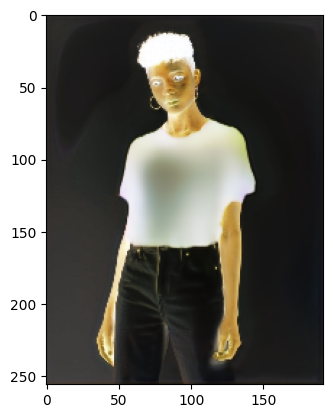

In [12]:
show_array_as_image(np.invert(np.uint8(255*model_output)))